In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
sub = xr.open_dataset('../data/netcdfs/banner_lowman_05208_21019-019_21021-007_0006d.nc')

In [3]:
print(sub['VV-cor'].shape)
sub = sub.coarsen(x=4, boundary = 'trim').mean().coarsen(y=4, boundary = 'trim').mean()
print(sub['VV-cor'].shape)
for name, values in sub.items():
    if name != 'dem':
        sub[name] = sub[name].where(sub['dem'] > 0)
sub['dem'] = sub['dem'].where(sub['dem'] > 0)

sub['easting'] = (('x','y'),np.degrees(np.cos(sub['aspect'].values)))
sub['northing'] = (('x','y'),np.degrees(np.sin(sub['aspect'].values)))

sub['inc'] = np.degrees(sub['inc'])

(3661, 6306)
(915, 1576)


In [4]:
def measure(model, test):
    X = test.drop(['target'],axis =1)
    y = test.target
    # adjusted R-squared
    return (1 - ( 1-model.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ))

## Make Data

In [5]:
y = sub['VV-cor'].values.ravel() #[100:3000,100:2700]

ls = ['trees','dem','tmean','ppt_total','land_forms','land_class','northing','easting']
data = pd.DataFrame()
for var in ls:
    x = sub[var].values.ravel() #[100:3000,100:2700]
    x = x[~np.isnan(y)]

    data[var] = x

y = y[~np.isnan(y)]
data['target'] = y

data.land_forms = data.land_forms.astype('category')
data.target = data.target.astype('category')
data.land_class = data.land_class.astype('category')

train, test = train_test_split(data)

## Build Pipeline

In [6]:
categorical_features = data.select_dtypes('category').columns.drop('target')
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

numeric_features = data.select_dtypes('float64').columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)])

## MLP Regressor

In [7]:
from sklearn.neural_network import MLPRegressor

y = train.target
X = train.drop(['target'],axis = 1)

mlr_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('classify', MLPRegressor(hidden_layer_sizes = (100, 50, 25,), activation = 'relu', alpha = 0.0001))
])


mlr_pipe.fit(X, y)

print('Ajd- R2')
print(1 - ( 1-mlr_pipe.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ))

print('Test Adjusted R2')
print(measure(mlr_pipe))

Test Ajd- R2
0.29071360210404273
Adjusted R2
0.2697402468314757


In [8]:
sub_ext = [300,600,200,600]
y = sub['VV-cor'][sub_ext[0]:sub_ext[1],sub_ext[2]:sub_ext[3]].values.ravel() #[100:3000,100:2700]

im_data = pd.DataFrame()
for var in ls:
    x = sub[var][sub_ext[0]:sub_ext[1],sub_ext[2]:sub_ext[3]].values.ravel() #[100:3000,100:2700]
#     x = x[~np.isnan(y)]

    im_data[var] = x

# y = y[~np.isnan(y)]
im_data['target'] = y

y = im_data.target
X = im_data.drop(['target'],axis = 1)

preds = mlr_pipe.predict(X).reshape((sub_ext[1]-sub_ext[0],sub_ext[3]-sub_ext[2]))

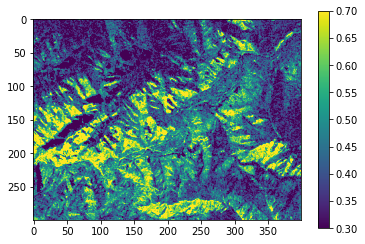

In [9]:
sub_ext = [300,600,200,600]
plt.imshow(sub['VV-cor'][sub_ext[0]:sub_ext[1],sub_ext[2]:sub_ext[3]], vmin = 0.3, vmax = 0.7)
plt.colorbar()
plt.show()

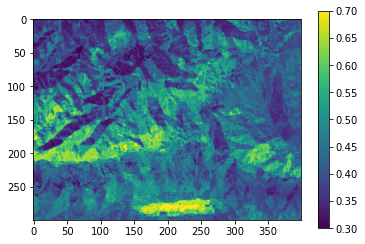

In [10]:
plt.imshow(preds, vmin = 0.3, vmax = 0.7)
plt.colorbar()

## Feature Importance

In [12]:
sub_ext = [300,600,200,600]
def model_subset(ls, model = MLPRegressor(hidden_layer_sizes = (100, 50, 25,), activation = 'relu', alpha = 0.0001), target_pol = 'VV'):
    y = sub[f'{target_pol}-cor'].values.ravel() #[100:3000,100:2700]

    data = pd.DataFrame()
    for var in ls:
        x = sub[var].values.ravel() #[100:3000,100:2700]
        x = x[~np.isnan(y)]

        data[var] = x
        if var == 'land_forms' or var == 'land_class':
            data[var] = data[var].astype('category')
        else:
            data[var] = data[var].astype('float64')


    y = y[~np.isnan(y)]
    data['target'] = y
    data.target = data.target.astype('category')
    categorical_features = data.select_dtypes('category').columns.drop('target')
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    numeric_features = data.select_dtypes('float64').columns
    numeric_transformer = Pipeline(
        steps=[("scaler", StandardScaler())])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)])

    train, test = train_test_split(data)

    from sklearn.neural_network import MLPRegressor

    y = train.target
    X = train.drop(['target'],axis = 1)

    mlr_pipe = Pipeline([
        ('preprocess', preprocessor),
        ('classify', model)
    ])


    mlr_pipe.fit(X, y)

    print('Ajd- R2')
    print(1 - ( 1-mlr_pipe.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ))

    print('Test Adjusted R2')
    print(measure(mlr_pipe, test))

    y = sub['VV-cor'][sub_ext[0]:sub_ext[1],sub_ext[2]:sub_ext[3]].values.ravel() #[100:3000,100:2700]

    im_data = pd.DataFrame()
    for var in ls:
        x = sub[var][sub_ext[0]:sub_ext[1],sub_ext[2]:sub_ext[3]].values.ravel() #[100:3000,100:2700]
        im_data[var] = x

    im_data['target'] = y

    y = im_data.target
    X = im_data.drop(['target'],axis = 1)

    preds = mlr_pipe.predict(X).reshape((sub_ext[1]-sub_ext[0],sub_ext[3]-sub_ext[2]))

    plt.imshow(preds, vmin = 0.3, vmax = 0.7)
    plt.colorbar()
    plt.show()

## Dummy Model - No Inputs

Ajd- R2
-0.026615963446968482
Test Adjusted R2
-0.02707057234404342


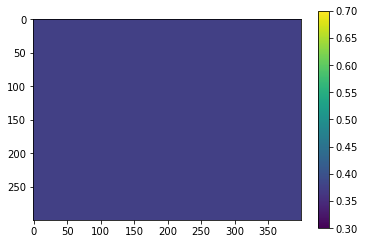

In [62]:
ls = ['trees','dem','tmean','ppt_total','land_forms','land_class','northing','easting']
model_subset(ls, model = DummyRegressor(strategy = 'median'))

## Topography Only

Ajd- R2
0.20503384255461277
Test Adjusted R2
0.20574351224806153


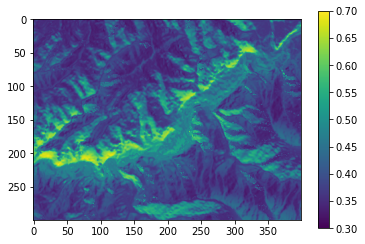

In [34]:
ls = ['dem','slope','easting','northing']
model_subset(ls)

## Topography and Trees

Ajd- R2
0.220602456629431
Test Adjusted R2
0.22059438573200563


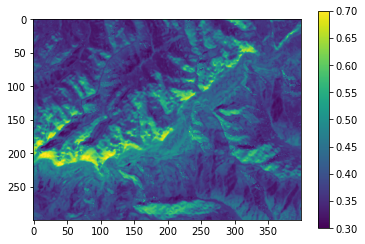

In [63]:
ls = ['dem','slope','easting','northing','trees']
model_subset(ls)

## Topography, Trees, and Land Classifications

Ajd- R2
0.2831485335785029
Test Adjusted R2
0.25960140636893037


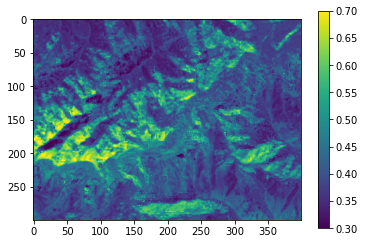

In [64]:
ls = ['dem','slope','easting','northing','trees','land_class','land_forms']
model_subset(ls)

## Topography, Trees, Land Classifications, Wx

Ajd- R2
0.38567196719012575
Test Adjusted R2
0.3635505144667581


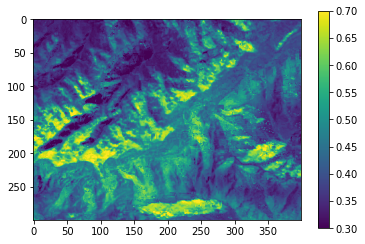

In [65]:
ls = ['dem','slope','easting','northing','trees','land_class','land_forms','tmean','ppt_total']

model_subset(ls)

Ajd- R2
0.3228187257497154
Test Adjusted R2
0.30139121734245644


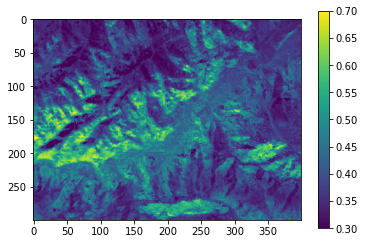

In [13]:
ls = ['dem','slope','easting','northing','trees','land_class','land_forms','tmean']

model_subset(ls)

Ajd- R2
0.3500766134957486
Test Adjusted R2
0.3211362388704402


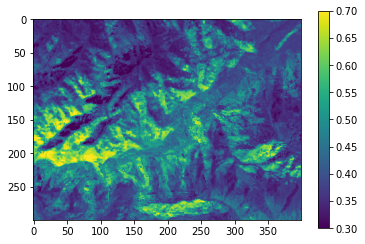

In [14]:
ls = ['dem','slope','easting','northing','trees','land_class','land_forms','ppt_total']

model_subset(ls)

## SAR Properties

Ajd- R2
0.8019314498181758
Test Adjusted R2
0.7978290701498436


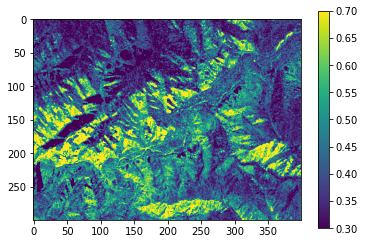

In [78]:
#a list with the variable names of your xarray.Dataset
res = [i for i in sub.data_vars if 'cor' not in i] 
model_subset(ls = res)

# VH NOW

## True

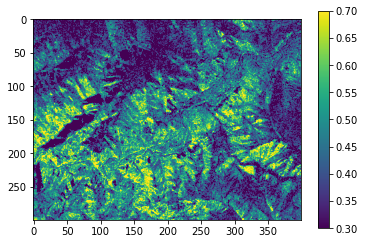

In [84]:
sub_ext = [300,600,200,600]
plt.imshow(sub['VH-cor'][sub_ext[0]:sub_ext[1],sub_ext[2]:sub_ext[3]], vmin = 0.3, vmax = 0.7)
plt.colorbar()
plt.show()

## Dummy

Ajd- R2
-0.022486042900811576
Test Adjusted R2
-0.02214741737626902


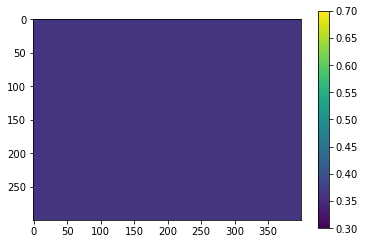

In [80]:
ls = ['trees','dem','tmean','ppt_total','land_forms','land_class','northing','easting']
model_subset(ls, model = DummyRegressor(strategy = 'median'), target_pol = 'VH')

## Topography

Ajd- R2
0.20079926466335385
Test Adjusted R2
0.20092222583104036


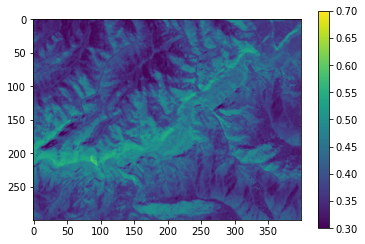

In [81]:
ls = ['dem','slope','easting','northing','trees']
model_subset(ls, target_pol = 'VH')

## Topography and Trees

Ajd- R2
0.2010604836219163
Test Adjusted R2
0.19808407587111498


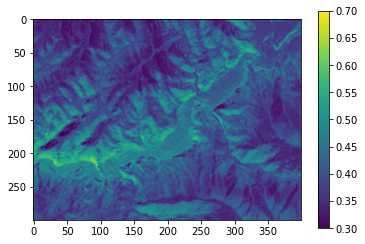

In [82]:
ls = ['dem','slope','easting','northing','trees']
model_subset(ls, target_pol = 'VH')

## Topography, Trees, and Land Classifications

Ajd- R2
0.2611763945906529
Test Adjusted R2
0.2471536831608082


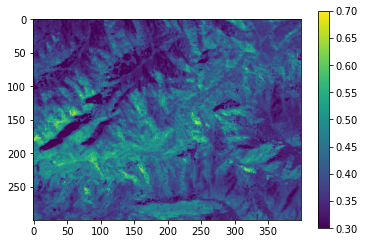

In [83]:
ls = ['dem','slope','easting','northing','trees','land_class','land_forms']
model_subset(ls, target_pol = 'VH')

## Topography, Trees, Land Classifications, Wx

Ajd- R2
0.37824208905704815
Test Adjusted R2
0.35855371370572364


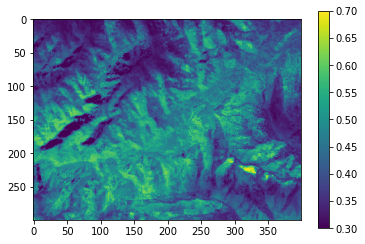

In [85]:
ls = ['dem','slope','easting','northing','trees','land_class','land_forms','tmean','ppt_total']
model_subset(ls, target_pol = 'VH')